In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
'''
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters
'''

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
%matplotlib inline

In [2]:
path = "data/"
train_data = pd.read_csv(path+'train.csv')
test_data = pd.read_csv(path+'test.csv')

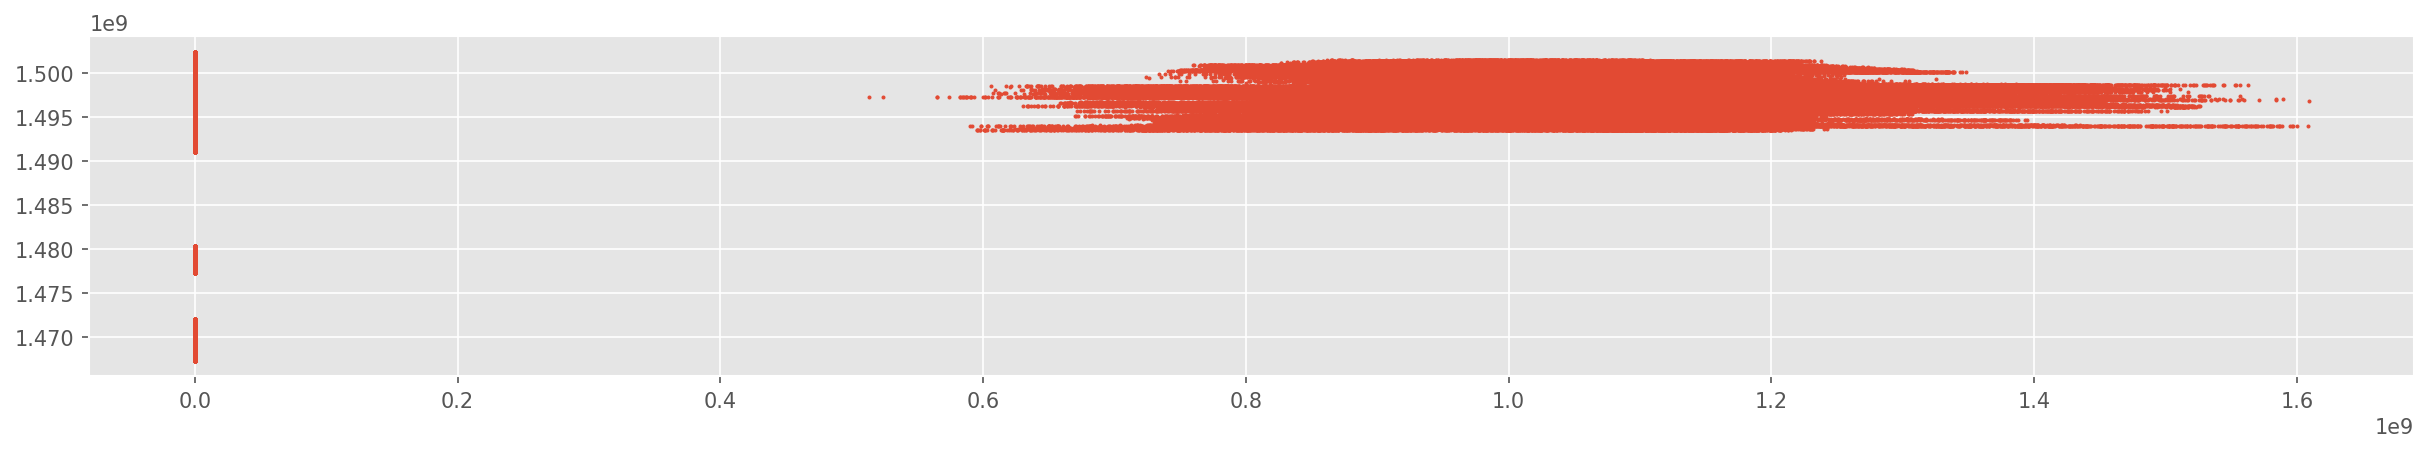

In [87]:
fig = plt.figure(figsize=(20,3),dpi=150)
plt.scatter(train_data['timestamp'],train_data['value'],s=2)
fig.savefig('whole.png',dpi=150)

In [5]:
kpi_group = list(set(train_data["KPI ID"]))

In [6]:
for i in kpi_group:
    print("KPI ID ",i,"length :",len(train_data[train_data['KPI ID']==i]))

KPI ID  7c189dd36f048a6c length : 147689
KPI ID  046ec29ddf80d62e length : 8784
KPI ID  76f4550c43334374 length : 8784
KPI ID  c58bfcbacb2822d1 length : 128667
KPI ID  8a20c229e9860d0c length : 8784
KPI ID  88cf3a776ba00e7c length : 65436
KPI ID  b3b2e6d1a791d63a length : 8247
KPI ID  02e99bd4f6cfb33f length : 128562
KPI ID  18fbb1d5a5dc099d length : 129128
KPI ID  9bd90500bfd11edb length : 128613
KPI ID  a5bf5d65261d859a length : 128679
KPI ID  8c892e5525f3e491 length : 147009
KPI ID  09513ae3e75778a3 length : 128971
KPI ID  da403e4e3f87c9e0 length : 129035
KPI ID  07927a9a18fa19ae length : 10960
KPI ID  1c35dbf57f55f5e4 length : 128853
KPI ID  e0770391decc44ce length : 147024
KPI ID  8bef9af9a922e0b3 length : 129453
KPI ID  40e25005ff8992bd length : 100254
KPI ID  affb01ca2b4f0b45 length : 147680
KPI ID  9ee5879409dccef9 length : 65449
KPI ID  769894baefea4e9e length : 8784
KPI ID  71595dd7171f4540 length : 147668
KPI ID  a40b1df87e3f1c87 length : 137925
KPI ID  54e8a140f6237526 leng

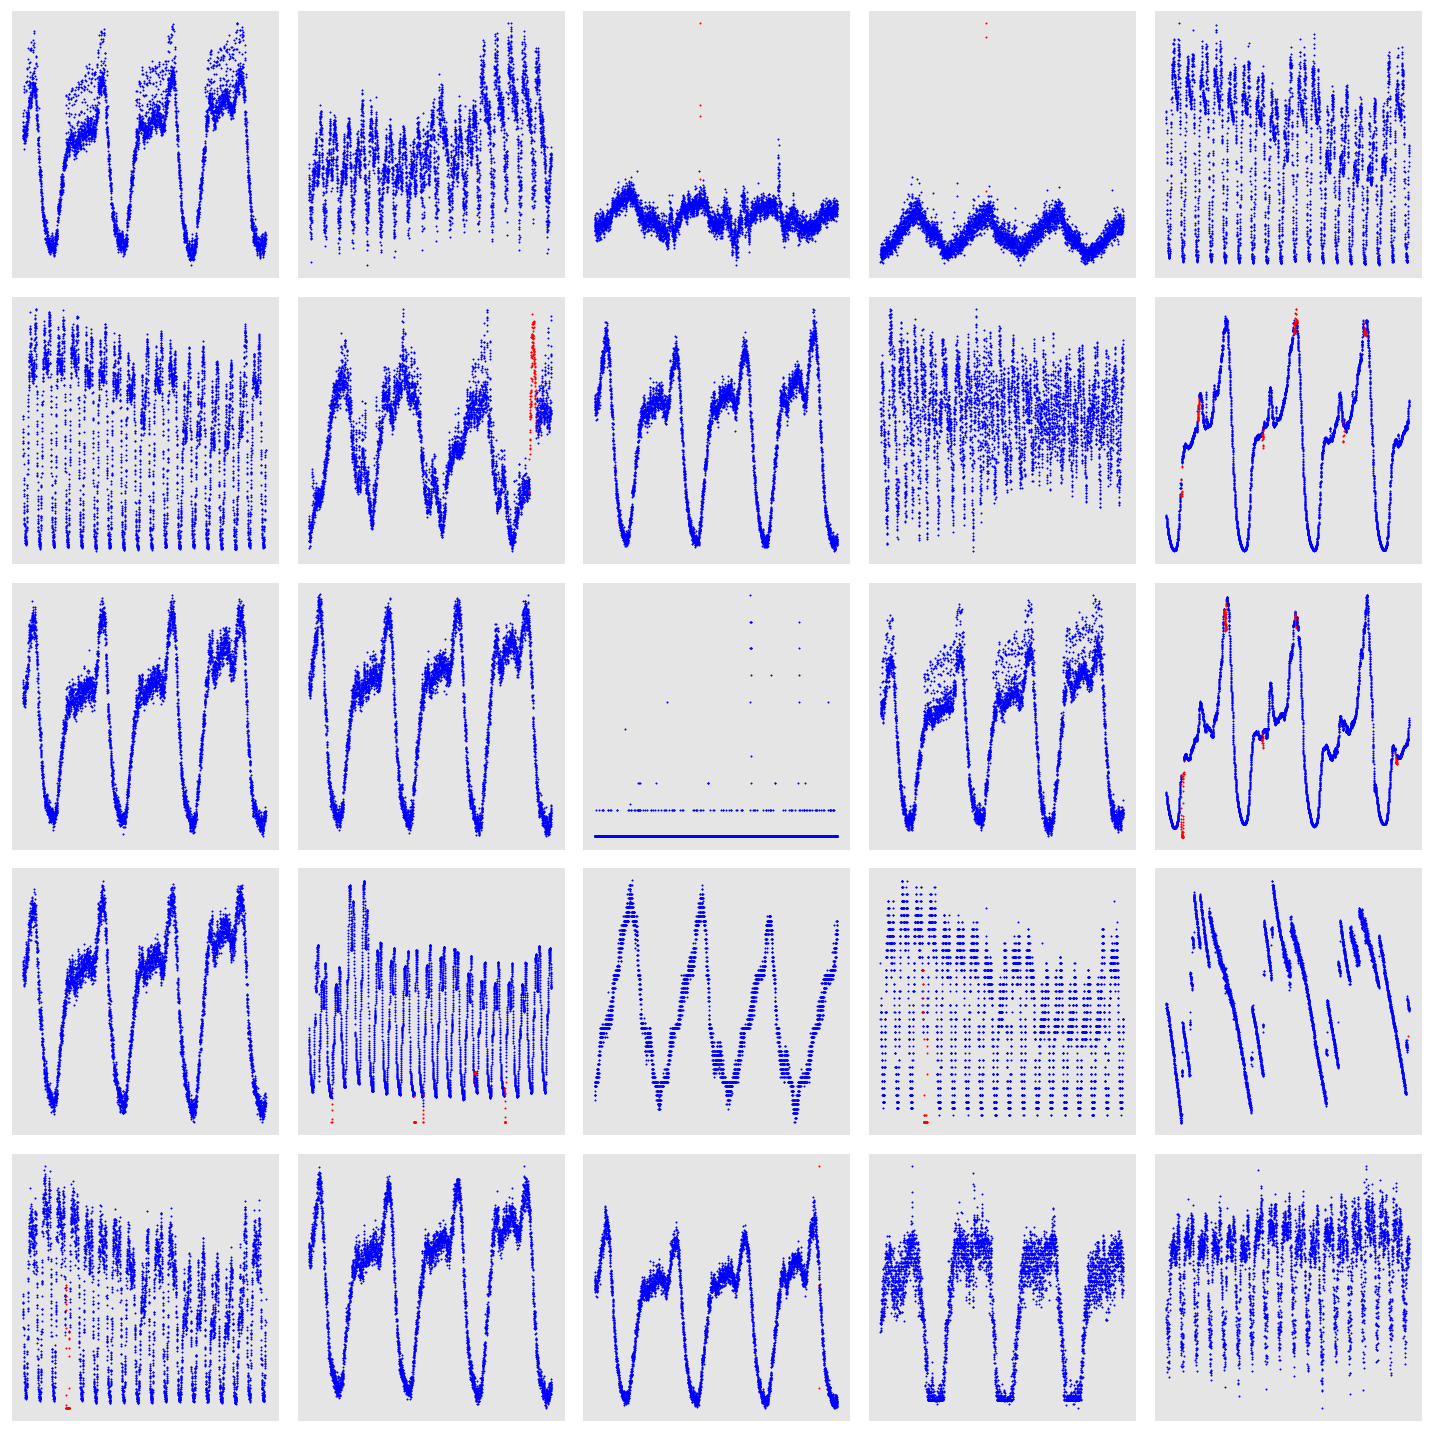

In [56]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20,20))
for i, ax in enumerate(axes.flat, start=1):
    group = train_data[train_data['KPI ID']==kpi_group[i]]
    sample_len = 5000
    head_data = group[:sample_len]
    for i in range(sample_len):
        if head_data.iloc[i]['label'] != 0:
            ax.scatter(i, head_data.iloc[i]['value'], c='red', s=2)
        else:
            ax.scatter(i, head_data.iloc[i]['value'], c='blue', s=2)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
fig.savefig('data.png', dpi=200)

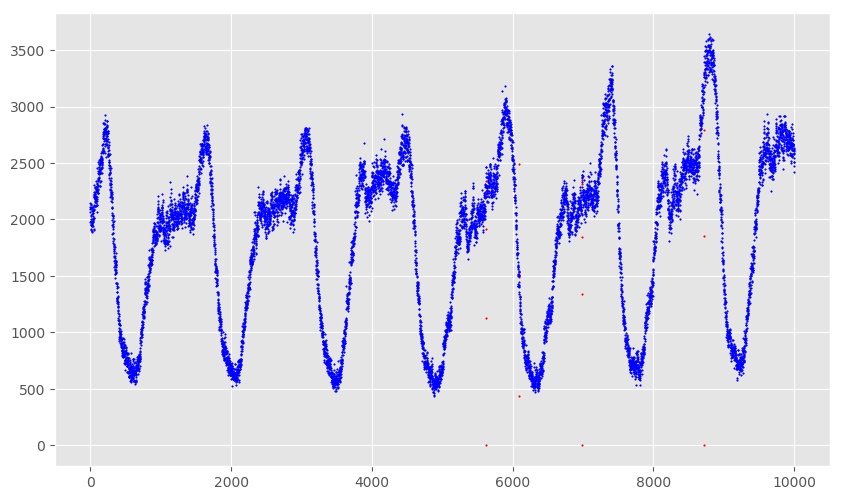

In [30]:
sample_len = 10000
head_data = first_type[:sample_len]
for i in range(sample_len):
    if head_data.iloc[i]['label'] != 0:
        plt.scatter(i, head_data.iloc[i]['value'], c='red', s=1)
    else:
        plt.scatter(i, head_data.iloc[i]['value'], c='blue', s=1)

In [4]:
train_target = train_data["label"]
#train_data = np.array(train_data['value']).reshape(-1,1,1)
train_target = pd.get_dummies(train_target)

In [7]:
train_x, test_x, train_y, test_y = train_test_split(train_data['value'], train_target, test_size=0.2)

## Sample one KPI ID group as toy dataset

In [13]:
type_data_1 = train_data[train_data["KPI ID"]=="046ec29ddf80d62e"]

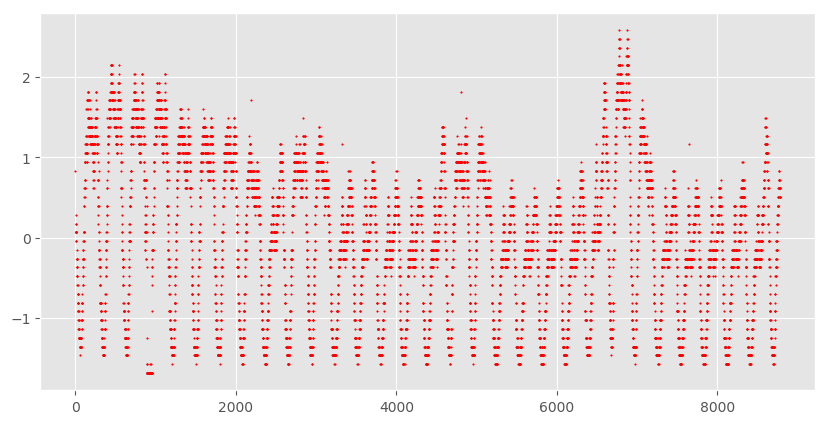

In [14]:
fig = plt.figure(figsize=(10,5),dpi=100)
head_data = type_data_1
sample_len = type_data_1.shape[0]
plt.scatter(range(sample_len), head_data['value'], c='red', s=1)

In [15]:
train_x_1 = np.array(type_data_1['value'])
len_x_1 = train_x_1.shape[0]
train_y_1 = np.array(type_data_1['label'])

# MR / MR_diff (not complete)
import statsmodels.api as sm

def get_MR_value(data, win_size):
    order = (0, win_size)
    tempModel = sm.tsa.ARMA(data, order).fit()
    delta = tempModel.fittedvalues
    return delta

def get_MR_Diff(MR_list):
    former_diff = []
    later_diff = []
    for index, value in enumerate(MR_list):
        if index - 1 < 0:
            former_diff.append(0)
        else:
            former_diff.append(value-MR_list[index-1])
        if index + 1 > MR_list.shape[0] - 1:
            later_diff.append(0)
        else:
            later_diff.append(MR_list[index+1]-value)
    return np.concatenate([np.array(former_diff).reshape(-1,1)\
                               ,np.array(later_diff).reshape(-1,1)], axis=1)
    
def get_MR_features(data, win_size_list, diff=False):
    feature_arr = []
    for win_size in win_size_list:
        temp = get_MR_value(data, win_size).reshape(-1,1)
        if diff:
            pass
        if feature_arr == []:
            feature_arr = temp
        else:
            feature_arr = np.concatenate([feature_arr, temp], axis=1)
    return feature_arr

In [16]:
def get_EWMA_feature(data, alpha_list):
    data_pd = pd.DataFrame(data)
    new_feature = []
    for each_alpha in alpha_list:
        temp = data_pd.ewm(alpha=each_alpha).mean()
        #print(temp.shape)
        if type(new_feature) == list:
            new_feature = temp
        else:
            new_feature = pd.concat([new_feature, temp], axis=1)
    return np.array(new_feature)

In [17]:
def get_2rd_exp_smooth(data, alpha, beta):
    data_len = data.shape[0]
    s_1_pre = data[0]
    s_2_pre = data[0]
    exp_smooth_list = []
    for i in range(data_len):
        s_1 = alpha * data[i] + (1 - alpha) * s_1_pre
        s_2 = alpha * s_1 + (1 - alpha) * s_2_pre
        a = 2 * s_1 - s_2
        b = alpha * (s_1 - s_2) / (1 - alpha) 
        f = a + beta * b
        exp_smooth_list.append(f)
    return np.array(exp_smooth_list).reshape(-1,1)

def get_ExpSmooth_feature(data, alpha_list, beta_list):
    feature_arr = []
    len_alpha = len(alpha_list)
    len_beta = len(beta_list)
    if len_alpha != len_beta:
        return feature_arr
    else:
        for alpha, beta in zip(alpha_list, beta_list):
            temp = get_2rd_exp_smooth(data, alpha, beta)
            #print(temp.shape)
            if type(feature_arr) == list:
                feature_arr = temp
            else:
                feature_arr = np.concatenate([feature_arr, temp], axis=1)
    return feature_arr
    

In [18]:
# Locally weighted scatterplot smoothing
# Don't know how to generate feature through this method
# skip here first

In [19]:
# get the diff with forward (stride > 0) and backward (stride < 0)
def get_diff(data, stride):
    data_len = data.shape[0]
    diff_list = []
    if stride > 0:
        for i in range(data_len):
            if i < stride:
                diff_list.append(0)
            else:
                diff_list.append(data[i] - data[i-stride])
    else:
        for i in range(data_len):
            if i >= data_len + stride:    # notice that stride here is a negative value
                diff_list.append(0)
            else:
                diff_list.append(data[i] - data[i-stride])
    return np.array(diff_list).reshape(-1,1)

def get_diff_feature(data, stride_list):
    feature_arr = []
    len_stride = len(stride_list)
    for stride in stride_list:
        temp = get_diff(data, stride)
        #print(temp.shape)
        if type(feature_arr) == list:
            feature_arr = temp
        else:
            feature_arr = np.concatenate([feature_arr, temp], axis=1)
    return feature_arr

In [20]:
# extract HoltWinter features
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd

def get_hw_feature(data):
    es_model = ExponentialSmoothing(data).fit()
    data_pd = pd.DataFrame(data)
    new_feature = es_model.predict(start=data_pd.index[0], end=data_pd.index[-1])
    return np.array(new_feature).reshape(-1, 1)

In [21]:
def get_wavelet(data, wl_type, mode='constant'):
    w = pywt.Wavelet(wl_type)
    cA, _ = pywt.dwt(data, wavelet=w, mode=mode)
    return np.array(cA).reshape(-1, 1)

def get_wavelet_feature(data, wl_type_list, mode_list):
    len_wl_list = len(wl_type_list)
    len_mode_list = len(mode_list)
    feature_arr = []
    if len_mode_list != 0:
        for wl_type, mode in zip(wl_type_list, mode_list):
            temp = get_wavelet(data, wl_type, mode)
            #print(temp.shape)
            if type(feature_arr) == list:
                feature_arr = temp
            else:
                feature_arr = np.concatenate([feature_arr, temp], axis=1)
    else:
        for wl_type in wl_type_list:
            temp = get_wavelet(data, wl_type)
            #print(temp.shape)
            if type(feature_arr) == list:
                feature_arr = temp
            else:
                feature_arr = np.concatenate([feature_arr, temp], axis=1)
    return feature_arr

In [22]:
feature_MA = get_MR_features(train_x_1, [5, 10, 20])

KeyboardInterrupt: 

In [25]:
#feature_MA = get_MR_features(train_x_1, [5, 10, 20])
feature_EWMA = get_EWMA_feature(train_x_1, [0.1, 0.3, 0.5, 0.7, 0.9])
feature_ExpSmooth = get_ExpSmooth_feature(train_x_1, [0.2,0.4,0.6,0.8],[0.4,0.6,0.4,0.2])
feature_diff = get_diff_feature(train_x_1, [-5, -1, 1, 5])
feature_HW = get_hw_feature(train_x_1)
all_feature = feature_EWMA
all_feature = np.concatenate([all_feature, feature_ExpSmooth], axis=1)
all_feature = np.concatenate([all_feature, feature_diff], axis=1)
all_feature = np.concatenate([all_feature, feature_HW], axis=1)

In [32]:
train_y_1.shape
print(all_feature.shape)

(8784, 14)


In [33]:
x_y = np.concatenate([all_feature, train_y_1.reshape(-1,1)], axis=1)

In [36]:
x_y_pd = pd.DataFrame(x_y)
x_y_pd.to_csv('046ec29ddf80d62e.csv', index=False)

In [23]:
train_x_1 = np.array(type_data_1['value'])
len_x_1 = train_x_1.shape[0]
train_y_1 = np.array(type_data_1['label'])
feature_list = []
for i in range(len_x_1):
    if i - 1 < 0:
        former = train_x_1[i]
    else:
        former = train_x_1[i-1]
    if i + 1 > len_x_1 - 1:
        later = train_x_1[i]
    else:
        later = train_x_1[i+1]
    feature_list.append((train_x_1[i] - former) * (train_x_1[i] - later))
feature_list = np.array(feature_list)
new_feature_list = []
for i in feature_list:
    if i > 1.34 or i < -0.5:
        new_feature_list.append(i)

In [20]:
anomaly_list = []
for index,label in enumerate(train_y_1):
    if label == 1:
        anomaly_list.append(feature_list[index])

In [22]:
anomaly_list

[0.06438961693167107,
 -0.9066679506236415,
 21.326081099257273,
 -0.9205535833074567,
 -0.008329078981751606,
 -0.004130209853071347,
 0.020949838116399402,
 0.17047298452104875,
 1.3436735230551748,
 -0.46162012406158565,
 -0.06436416213301485,
 0.0425021790395898]

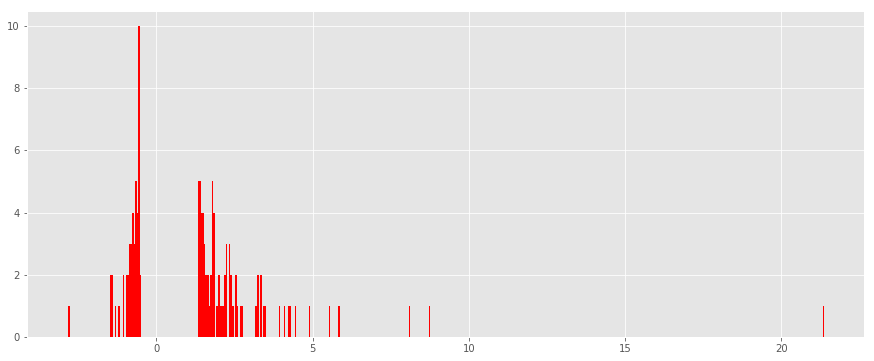

In [24]:
bins = np.arange(min(feature_list)-0.1,max(feature_list)+0.1,0.05)
fig,ax = plt.subplots(figsize=(15,6))
_ = ax.hist(new_feature_list,bins=bins,facecolor='red')

In [103]:
'''
time_decay = 7
train_len = train_data.shape[0]
shift_time = train_len - time_decay + 1
extracted_list = []
for i in range(shift_time):
    extracted_features = extract_features(train_data[i:i+6], column_id="label", column_sort="timestamp", n_jobs=5)
    extracted_list.append(extracted_features)
'''







Feature Extraction:   0%|          | 0/1 [00:00<?, ?it/s]





Feature Extraction: 100%|██████████| 1/1 [01:04<00:00, 64.58s/it]





 'value__friedrich_coefficients__m_3__r_30__coeff_1'
 'value__friedrich_coefficients__m_3__r_30__coeff_2'
 'value__friedrich_coefficients__m_3__r_30__coeff_3'
 'value__max_langevin_fixed_point__m_3__r_30'] did not have any finite values. Filling with zeros.


'\ntime_decay = 7\ntrain_len = train_data.shape[0]\nshift_time = train_len - time_decay + 1\nextracted_list = []\nfor i in range(shift_time):\n    extracted_features = extract_features(train_data[i:i+6], column_id="label", column_sort="timestamp", n_jobs=5)\n    extracted_list.append(extracted_features)\n'

In [5]:
train_X, test_X = train_x_1[:8000], train_x_1[8000:]
train_y_1 = pd.get_dummies(train_y_1)
train_y, test_y = train_y_1[:8000], train_y_1[8000:]

In [6]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import BatchNormalization, Bidirectional, TimeDistributed, Embedding
from keras.layers.recurrent import LSTM

from keras.optimizers import Adam

model = Sequential()
#input_shape = (1 ,1)
#model.add(Bidirectional(LSTM(units=10,return_sequences=True),input_shape=input_shape))
#model.add(Dropout(0.5))
#model.add(BatchNormalization())
#model.add(TimeDistributed(Dense(3, activation='sigmoid')))
# model.add(Dense(1, activation='sigmoid'))

model.add(Embedding(100, 32, input_length=1))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))


Using TensorFlow backend.


In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1, 32)             3200      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              132096    
__________

In [54]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [55]:
# LSTM参数个数计算：ht-1与xt拼接、隐藏单元数、四个门的bias
#                    （20+40）*units*4+20*4
#
#
adam = Adam(lr=0.01)
batch_size = 10000
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy',f1])
model.fit(train_X, train_y,
          batch_size=batch_size,
          epochs=30,
          validation_data=(test_X, test_y),
          verbose=1)

Train on 8000 samples, validate on 2960 samples
Epoch 1/30
8000/8000 [==============================] - 4s 446us/step - loss: 0.2124 - acc: 0.9868 - f1: 0.9867 - val_loss: 0.1300 - val_acc: 0.9919 - val_f1: 0.9919
Epoch 2/30
8000/8000 [==============================] - 0s 5us/step - loss: 0.2124 - acc: 0.9868 - f1: 0.9867 - val_loss: 0.1300 - val_acc: 0.9919 - val_f1: 0.9919
Epoch 3/30
8000/8000 [==============================] - 0s 5us/step - loss: 0.2124 - acc: 0.9868 - f1: 0.9867 - val_loss: 0.1300 - val_acc: 0.9919 - val_f1: 0.9919
Epoch 4/30
8000/8000 [==============================] - 0s 5us/step - loss: 0.2124 - acc: 0.9868 - f1: 0.9867 - val_loss: 0.1300 - val_acc: 0.9919 - val_f1: 0.9919
Epoch 5/30
8000/8000 [==============================] - 0s 5us/step - loss: 0.2124 - acc: 0.9868 - f1: 0.9867 - val_loss: 0.1300 - val_acc: 0.9919 - val_f1: 0.9919
Epoch 6/30
8000/8000 [==============================] - 0s 5us/step - loss: 0.2124 - acc: 0.9868 - f1: 0.9867 - val_loss: 0.1300 -

array([0.02718344, 0.57605951, 0.07788637, 0.46470245, 0.60013337,
       0.43410847, 0.92650801, 0.66430176, 0.29539827, 0.67594997])